# LSTM

In this notebook, we will go through basics of LSTM, GRU and Bi-LSTM using pretrained embeddings like glove and fasttext and  also custom embeddings on IMDB dataset. 

Here we will use [PyTorch](https://pytorch.org/tutorials/  "PyTorch Tutorial").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/lstm/gru/nlp/2019/01/28/Force-of-LSTM-and-GRU/). This is notebook which replicates the result of blog and runs in colab. Enjoy!

Let's see at [nlpprogess](http://nlpprogress.com/english/sentiment_analysis.html) what is the current state-of-the-art in sentiment analysis.


Model | Accuracy | Paper |
----- | -------- | ------|
ULMFit| 95.4     | [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146)|
Block-sparse LSTM| 94.99 | [GPU Kernels for Block-Sparse Weights](https://s3-us-west-2.amazonaws.com/openai-assets/blocksparse/blocksparsepaper.pdf)|
oh-LSTM | 94.1 | [Supervised and Semi-Supervised Text Categorization using LSTM for Region Embeddings](https://arxiv.org/abs/1602.02373) |
Virtual adversarial training  | 94.1 | [Adversarial Training Methods for Semi-Supervised Text Classification](https://arxiv.org/abs/1605.07725) |
BCN+Char+CoVe | 91.8 | [Learned in Translation: Contextualized Word Vectors](https://arxiv.org/abs/1708.00107) |


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/lstm_and_gru/lstm_and_gru_pytorch.ipynb)


## IMDB data

Code Adapted from: [link](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb)

In [0]:
import numpy as np
import time
import copy
import torch
torch.manual_seed(11)
import torch.nn as nn
import torch.nn.functional as F
from torchtext import datasets
from torchtext import data
import torch.optim as optim
import random
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Training on...', device)

Training on... cuda


In [0]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [0]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
print('Number of training examples:', len(train_data))
print('Number of testing examples:', len(test_data))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 10.8MB/s]


Number of training examples: 25000
Number of testing examples: 25000


In [0]:
print (vars(train_data.examples[2]))

{'text': ['OK', ',', 'I', 'do', "n't", 'really', 'think', 'that', 'Trailer', 'Park', 'Boys', 'has', 'bad', 'story', 'lines', ',', 'because', 'they', 'kick', 'ass', '.', 'They', 'just', '...', 'conflict', 'with', 'each', 'other.<br', '/><br', '/>For', 'Example', ':', 'Near', 'the', 'end', 'of', 'the', 'movie', ',', 'it', 'shows', 'Ricky', 'and', 'Julian', 'telling', '"', 'Patrick', 'Lewis', '"', 'to', 'put', 'the', 'dog', 'down', 'and', 'walk', 'away', '.', 'Then', 'at', 'the', 'end', ',', 'it', 'shows', 'Ricky', 'and', 'Julian', 'saying', 'that', 'they', "'ve", 'been', 'in', 'jail', 'for', '2', 'years', '.', 'In', 'the', 'TV', 'series', 'pilot', ',', 'the', 'first', 'clip', 'they', 'show', 'is', 'the', 'same', 'clip', 'of', 'Ricky', 'and', 'Julian', 'yelling', 'at', '"', 'Patrick', 'Lewis', '"', '.', 'But', 'in', 'the', 'TV', 'series', ',', 'they', "'ve", 'supposedly', 'only', 'been', 'in', 'jail', 'for', '18', 'months.<br', '/><br', '/>Also', ',', 'they', 'give', 'us', 'the', 'impress

In [0]:
train_data, val_data = train_data.split(split_ratio=0.8)
print('Number of training examples:', len(train_data))
print('Number of validation examples:', len(val_data))

Number of training examples: 20000
Number of validation examples: 5000


## Glove

In [0]:
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:11, 6.55MB/s]                           
100%|█████████▉| 399966/400000 [00:20<00:00, 20356.93it/s]

In [0]:
print('Unique tokens in TEXT vocabulary:', len(TEXT.vocab))
print('Unique tokens in LABEL vocabulary:',len(LABEL.vocab))

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [0]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [0]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 232653), (',', 220816), ('.', 189387), ('and', 125574), ('a', 125107), ('of', 115377), ('to', 107754), ('is', 87429), ('in', 70454), ('I', 62331), ('it', 61420), ('that', 56650), ('"', 50472), ("'s", 49694), ('this', 48616), ('-', 42468), ('/><br', 41014), ('was', 40184), ('as', 34867), ('with', 34370)]


In [0]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [0]:
BATCH_SIZE = 64

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    device=device)

embedding_dim=100
hidden_dim=128

In [0]:
class LSTM_Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
      
      super(LSTM_Model, self).__init__()
      self.num_layers = 1
      self.batch_size = batch_size
      self.hidden_dim = hidden_dim
      
      self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=self.num_layers) 
      self.fc = nn.Linear(hidden_dim, 1)
      self.hidden = self.init_hidden()      
      
    def forward(self, sentence):
      
        embeds = self.word_embeddings(sentence)
        # [sent_len, batch_size] --> [sent_len, batch_size, emb_dim]
        lstm_out, self.hidden = self.lstm(embeds, self.hidden) 
        # [sent_len, batch_size, emb_dim] --> [seq_len, batch, num_directions*hidden_size]
        preds = self.fc(lstm_out[-1].squeeze(0))
        # [batch, num_directions * hidden_size] --> [batch_size, 1]
        return preds
      
      
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device))
        

In [0]:
model = LSTM_Model(vocab_size=len(TEXT.vocab), embedding_dim=100, hidden_dim=128, batch_size=BATCH_SIZE)
model.to(device)

LSTM_Model(
  (word_embeddings): Embedding(25002, 100)
  (lstm): LSTM(100, 128)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [0]:
model.word_embeddings.weight.data.copy_(pretrained_embeddings)
model.word_embeddings.weight.requires_grad = False

In [0]:
parameters = filter(lambda p: p.requires_grad, model.parameters())

optimizer = optim.Adam(parameters, lr=1e-3, amsgrad=True)
criterion = nn.BCEWithLogitsLoss()

In [0]:
# Create training and validation dataloaders
dataloaders_dict = {'train': train_iterator, 
                    'val': val_iterator}

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, batch_size=BATCH_SIZE):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    skip_count = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs, labels = data.text, data.label
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # we need to clear out the hidden state of the LSTM,
                        # detaching it from its history on the last instance.
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)


                # statistics
                running_loss += loss.item()
                outputs = torch.round(torch.sigmoid(outputs))
                corrects = (outputs == labels).float()
                acc = corrects.sum()/len(corrects)
                running_corrects += acc.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [0]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


100%|█████████▉| 399966/400000 [00:40<00:00, 20356.93it/s]

train Loss: 0.6934 Acc: 0.5037
val Loss: 0.6932 Acc: 0.4990
Epoch 1/9
----------
train Loss: 0.6931 Acc: 0.4985
val Loss: 0.6921 Acc: 0.4956
Epoch 2/9
----------
train Loss: 0.6929 Acc: 0.5042
val Loss: 0.6913 Acc: 0.5257
Epoch 3/9
----------
train Loss: 0.6928 Acc: 0.5014
val Loss: 0.6919 Acc: 0.5047
Epoch 4/9
----------
train Loss: 0.6925 Acc: 0.5001
val Loss: 0.6912 Acc: 0.4921
Epoch 5/9
----------
train Loss: 0.6921 Acc: 0.5014
val Loss: 0.6927 Acc: 0.5222
Epoch 6/9
----------
train Loss: 0.6920 Acc: 0.5073
val Loss: 0.6901 Acc: 0.5109
Epoch 7/9
----------
train Loss: 0.6918 Acc: 0.5032
val Loss: 0.6893 Acc: 0.5190
Epoch 8/9
----------
train Loss: 0.6915 Acc: 0.4978
val Loss: 0.7057 Acc: 0.4929
Epoch 9/9
----------
train Loss: 0.6906 Acc: 0.5013
val Loss: 0.6934 Acc: 0.5443
Training complete in 8m 46s
Best val Acc: 0.544304


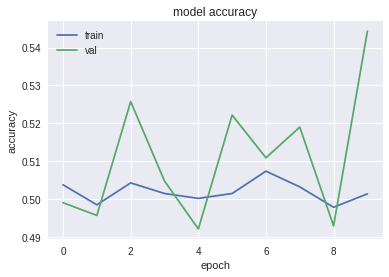

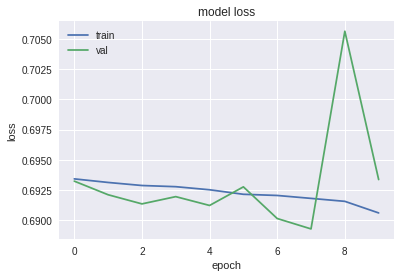

In [0]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## fasttext

In [0]:
TEXT.build_vocab(train_data, max_size=25000, vectors="fasttext.simple.300d")
LABEL.build_vocab(train_data)


.vector_cache/wiki.simple.vec: 0.00B [00:00, ?B/s]
.vector_cache/wiki.simple.vec:   0%|          | 8.19k/293M [00:00<6:54:44, 11.8kB/s]
.vector_cache/wiki.simple.vec:   0%|          | 24.6k/293M [00:00<5:03:00, 16.1kB/s]
.vector_cache/wiki.simple.vec:   0%|          | 57.3k/293M [00:00<3:38:26, 22.4kB/s]
.vector_cache/wiki.simple.vec:   0%|          | 123k/293M [00:01<2:36:03, 31.3kB/s] 
.vector_cache/wiki.simple.vec:   0%|          | 246k/293M [00:01<1:50:53, 44.0kB/s]
.vector_cache/wiki.simple.vec:   0%|          | 459k/293M [00:01<1:18:32, 62.1kB/s]
.vector_cache/wiki.simple.vec:   0%|          | 893k/293M [00:01<55:22, 88.0kB/s]  
.vector_cache/wiki.simple.vec:   1%|          | 1.70M/293M [00:01<38:55, 125kB/s]
.vector_cache/wiki.simple.vec:   1%|          | 3.40M/293M [00:01<27:12, 178kB/s]
.vector_cache/wiki.simple.vec:   2%|▏         | 6.00M/293M [00:01<18:57, 253kB/s]
.vector_cache/wiki.simple.vec:   3%|▎         | 8.68M/293M [00:02<13:13, 359kB/s]
.vector_cache/wiki.simple.ve

In [0]:
print('Unique tokens in TEXT vocabulary:', len(TEXT.vocab))
print('Unique tokens in LABEL vocabulary:',len(LABEL.vocab))

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [0]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 300])


In [0]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 232653), (',', 220816), ('.', 189387), ('and', 125574), ('a', 125107), ('of', 115377), ('to', 107754), ('is', 87429), ('in', 70454), ('I', 62331), ('it', 61420), ('that', 56650), ('"', 50472), ("'s", 49694), ('this', 48616), ('-', 42468), ('/><br', 41014), ('was', 40184), ('as', 34867), ('with', 34370)]


In [0]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [0]:
BATCH_SIZE = 64

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    device=device)

In [0]:
class LSTM_Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
      
      super(LSTM_Model, self).__init__()
      self.num_layers = 1
      self.batch_size = batch_size
      self.hidden_dim = hidden_dim
      
      self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=self.num_layers) 
      self.fc = nn.Linear(hidden_dim, 1)
      self.hidden = self.init_hidden()      
      
    def forward(self, sentence):
      
        embeds = self.word_embeddings(sentence)
        # [sent_len, batch_size] --> [sent_len, batch_size, emb_dim]
        lstm_out, self.hidden = self.lstm(embeds, self.hidden) 
        # [sent_len, batch_size, emb_dim] --> [seq_len, batch, num_directions*hidden_size]
        preds = self.fc(lstm_out[-1].squeeze(0))
        # [batch, num_directions*hidden_size] --> [batch_size, 1]
        return preds
      
      
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device))
        

In [0]:
model = LSTM_Model(vocab_size=len(TEXT.vocab), embedding_dim=300, hidden_dim=128, batch_size=BATCH_SIZE)
model.to(device)

LSTM_Model(
  (word_embeddings): Embedding(25002, 300)
  (lstm): LSTM(300, 128)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [0]:
model.word_embeddings.weight.data.copy_(pretrained_embeddings)
model.word_embeddings.weight.requires_grad = False

In [0]:
parameters = filter(lambda p: p.requires_grad, model.parameters())

optimizer = optim.Adam(parameters, lr=1e-3, amsgrad=True)
criterion = nn.BCEWithLogitsLoss()

In [0]:
# Create training and validation dataloaders
dataloaders_dict = {'train': train_iterator, 
                    'val': val_iterator}

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, batch_size=BATCH_SIZE):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    skip_count = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs, labels = data.text, data.label
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # we need to clear out the hidden state of the LSTM,
                        # detaching it from its history on the last instance.
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)


                # statistics
                running_loss += loss.item()
                outputs = torch.round(torch.sigmoid(outputs))
                corrects = (outputs == labels).float()
                acc = corrects.sum()/len(corrects)
                running_corrects += acc.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [0]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------



100%|█████████▉| 110624/111051 [00:28<00:00, 7678.10it/s]

train Loss: 0.6934 Acc: 0.5043
val Loss: 0.6936 Acc: 0.4915
Epoch 1/9
----------
train Loss: 0.6932 Acc: 0.5009
val Loss: 0.6925 Acc: 0.4937
Epoch 2/9
----------
train Loss: 0.6930 Acc: 0.5040
val Loss: 0.6939 Acc: 0.5117
Epoch 3/9
----------
train Loss: 0.6928 Acc: 0.5056
val Loss: 0.6930 Acc: 0.4864
Epoch 4/9
----------
train Loss: 0.6921 Acc: 0.5003
val Loss: 0.8428 Acc: 0.4976
Epoch 5/9
----------
train Loss: 0.6921 Acc: 0.5005
val Loss: 0.7026 Acc: 0.4840
Epoch 6/9
----------
train Loss: 0.6917 Acc: 0.5059
val Loss: 0.7041 Acc: 0.4931
Epoch 7/9
----------
train Loss: 0.6911 Acc: 0.5049
val Loss: 0.7238 Acc: 0.5107
Epoch 8/9
----------
train Loss: 0.6905 Acc: 0.5016
val Loss: 0.7196 Acc: 0.5020
Epoch 9/9
----------
train Loss: 0.6896 Acc: 0.5047
val Loss: 0.7418 Acc: 0.5030
Training complete in 9m 41s
Best val Acc: 0.511669


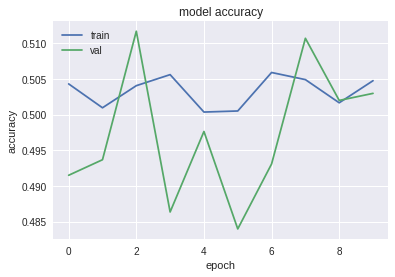

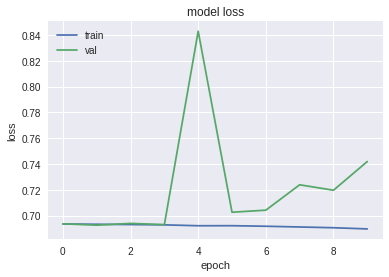

In [0]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Custom Embedding Layer using LSTM

In [0]:
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [0]:
print('Unique tokens in TEXT vocabulary:', len(TEXT.vocab))
print('Unique tokens in LABEL vocabulary:',len(LABEL.vocab))

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [0]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 232653), (',', 220816), ('.', 189387), ('and', 125574), ('a', 125107), ('of', 115377), ('to', 107754), ('is', 87429), ('in', 70454), ('I', 62331), ('it', 61420), ('that', 56650), ('"', 50472), ("'s", 49694), ('this', 48616), ('-', 42468), ('/><br', 41014), ('was', 40184), ('as', 34867), ('with', 34370)]


In [0]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [0]:
BATCH_SIZE = 64

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    device=device)

In [0]:
class LSTM_Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
      
      super(LSTM_Model, self).__init__()
      self.num_layers = 1
      self.batch_size = batch_size
      self.hidden_dim = hidden_dim
      
      self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=self.num_layers) 
      self.fc = nn.Linear(hidden_dim, 1)
      self.hidden = self.init_hidden()      
      
    def forward(self, sentence):
      
        embeds = self.word_embeddings(sentence)
        # [sent_len, batch_size] --> [sent_len, batch_size, emb_dim]
        lstm_out, self.hidden = self.lstm(embeds, self.hidden) 
        # [sent_len, batch_size, emb_dim] --> [seq_len, batch, num_directions*hidden_size]
        (hidden, cell) =  self.hidden
        preds = self.fc(lstm_out[-1].squeeze(0))
        # [batch, num_directions*hidden_size] --> [batch_size, 1]
        return preds
      
      
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device))
        

In [0]:
model = LSTM_Model(vocab_size=len(TEXT.vocab), embedding_dim=300, hidden_dim=128, batch_size=BATCH_SIZE)
model.to(device)

LSTM_Model(
  (word_embeddings): Embedding(25002, 300)
  (lstm): LSTM(300, 128)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
criterion = nn.BCEWithLogitsLoss()

In [0]:
# Create training and validation dataloaders
dataloaders_dict = {'train': train_iterator, 
                    'val': val_iterator}

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, batch_size=BATCH_SIZE):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    skip_count = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs, labels = data.text, data.label
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # we need to clear out the hidden state of the LSTM,
                        # detaching it from its history on the last instance.
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)


                # statistics
                running_loss += loss.item()
                outputs = torch.round(torch.sigmoid(outputs))
                corrects = (outputs == labels).float()
                acc = corrects.sum()/len(corrects)
                running_corrects += acc.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [0]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6944 Acc: 0.5022
val Loss: 0.6921 Acc: 0.5063
Epoch 1/9
----------
train Loss: 0.6928 Acc: 0.4967
val Loss: 0.6925 Acc: 0.5192
Epoch 2/9
----------
train Loss: 0.6912 Acc: 0.5061
val Loss: 0.6949 Acc: 0.5299
Epoch 3/9
----------
train Loss: 0.6896 Acc: 0.5057
val Loss: 0.6969 Acc: 0.5113
Epoch 4/9
----------
train Loss: 0.6882 Acc: 0.5063
val Loss: 0.6963 Acc: 0.5548
Epoch 5/9
----------
train Loss: 0.6872 Acc: 0.5032
val Loss: 0.6986 Acc: 0.5318
Epoch 6/9
----------
train Loss: 0.6806 Acc: 0.5523
val Loss: 0.7395 Acc: 0.5659
Epoch 7/9
----------
train Loss: 0.6429 Acc: 0.6541
val Loss: 0.5850 Acc: 0.7312
Epoch 8/9
----------
train Loss: 0.5076 Acc: 0.7909
val Loss: 0.5730 Acc: 0.6948
Epoch 9/9
----------
train Loss: 0.3957 Acc: 0.8481
val Loss: 0.4420 Acc: 0.8131
Training complete in 14m 20s
Best val Acc: 0.813093


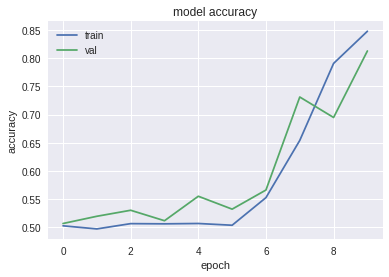

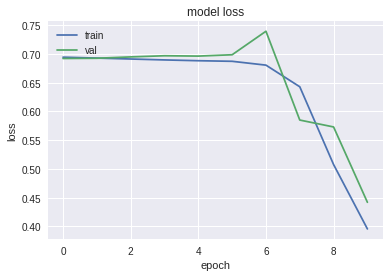

In [0]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Custom Embedding Layer using Bidirectional LSTM

In [0]:
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [0]:
print('Unique tokens in TEXT vocabulary:', len(TEXT.vocab))
print('Unique tokens in LABEL vocabulary:',len(LABEL.vocab))

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [0]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 232653), (',', 220816), ('.', 189387), ('and', 125574), ('a', 125107), ('of', 115377), ('to', 107754), ('is', 87429), ('in', 70454), ('I', 62331), ('it', 61420), ('that', 56650), ('"', 50472), ("'s", 49694), ('this', 48616), ('-', 42468), ('/><br', 41014), ('was', 40184), ('as', 34867), ('with', 34370)]


In [0]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [0]:
BATCH_SIZE = 64

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    device=device)

In [0]:
class BiLSTM_Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
      
      super(BiLSTM_Model, self).__init__()
      self.num_layers = 1
      self.batch_size = batch_size
      self.hidden_dim = hidden_dim
      
      self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=self.num_layers, bidirectional=True) 
      self.fc = nn.Linear(hidden_dim*2, 1)
      self.hidden = self.init_hidden()      
      
    def forward(self, sentence):
      
        embeds = self.word_embeddings(sentence)
        # [sent_len, batch_size] --> [sent_len, batch_size, emb_dim]
        bilstm_out, self.hidden = self.bilstm(embeds, self.hidden) 
        # [sent_len, batch_size, emb_dim] --> [seq_len, batch, num_directions*hidden_size]
        preds = self.fc(bilstm_out[-1])
        # [batch, num_directions*hidden_size] --> [batch_size, 1]
        return preds
      
      
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # The axes semantics are (num_layers*2, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers*2, self.batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers*2, self.batch_size, self.hidden_dim).to(device))
        

In [0]:
model = BiLSTM_Model(vocab_size=len(TEXT.vocab), embedding_dim=300, hidden_dim=128, batch_size=BATCH_SIZE)
model.to(device)

BiLSTM_Model(
  (word_embeddings): Embedding(25002, 300)
  (bilstm): LSTM(300, 128, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
criterion = nn.BCEWithLogitsLoss()

In [0]:
# Create training and validation dataloaders
dataloaders_dict = {'train': train_iterator, 
                    'val': val_iterator}

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, batch_size=BATCH_SIZE):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    skip_count = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs, labels = data.text, data.label
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # we need to clear out the hidden state of the LSTM,
                        # detaching it from its history on the last instance.
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)


                # statistics
                running_loss += loss.item()
                outputs = torch.round(torch.sigmoid(outputs))
                corrects = (outputs == labels).float()
                acc = corrects.sum()/len(corrects)
                running_corrects += acc.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [0]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6944 Acc: 0.5044
val Loss: 0.6929 Acc: 0.5105
Epoch 1/9
----------
train Loss: 0.6928 Acc: 0.4961
val Loss: 0.6942 Acc: 0.5196
Epoch 2/9
----------
train Loss: 0.6911 Acc: 0.5059
val Loss: 0.6975 Acc: 0.5235
Epoch 3/9
----------
train Loss: 0.6892 Acc: 0.5055
val Loss: 0.7004 Acc: 0.5216
Epoch 4/9
----------
train Loss: 0.6877 Acc: 0.5073
val Loss: 0.7012 Acc: 0.5368
Epoch 5/9
----------
train Loss: 0.6790 Acc: 0.5638
val Loss: 0.6614 Acc: 0.5963
Epoch 6/9
----------
train Loss: 0.5491 Acc: 0.7439
val Loss: 0.6189 Acc: 0.7551
Epoch 7/9
----------
train Loss: 0.4026 Acc: 0.8378
val Loss: 0.4393 Acc: 0.8172
Epoch 8/9
----------
train Loss: 0.2977 Acc: 0.8925
val Loss: 0.4131 Acc: 0.8331
Epoch 9/9
----------
train Loss: 0.2157 Acc: 0.9284
val Loss: 0.4260 Acc: 0.8420
Training complete in 18m 0s
Best val Acc: 0.841970


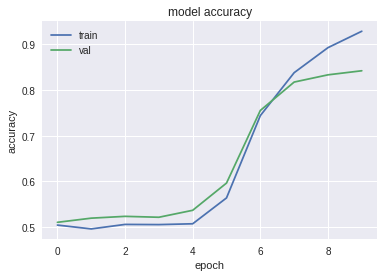

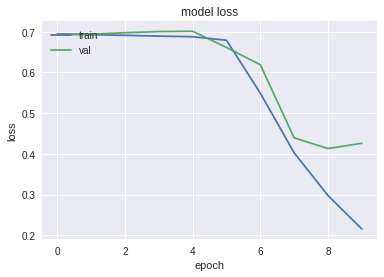

In [0]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Custom Embedding Layer using GRU

In [0]:
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [0]:
print('Unique tokens in TEXT vocabulary:', len(TEXT.vocab))
print('Unique tokens in LABEL vocabulary:',len(LABEL.vocab))

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [0]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 231930), (',', 220347), ('.', 188890), ('and', 125520), ('a', 125105), ('of', 115296), ('to', 107349), ('is', 86751), ('in', 70003), ('I', 62140), ('it', 61173), ('that', 56419), ('"', 50909), ("'s", 49412), ('this', 48255), ('-', 42354), ('/><br', 40754), ('was', 40203), ('as', 34887), ('with', 34164)]


In [0]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [0]:
BATCH_SIZE = 64

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    device=device)

In [0]:
class GRU_Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
      
      super(GRU_Model, self).__init__()
      self.num_layers = 1
      self.batch_size = batch_size
      self.hidden_dim = hidden_dim
      
      self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=self.num_layers)
      self.fc = nn.Linear(hidden_dim, 1)
      self.hidden = self.init_hidden()      
      
    def forward(self, sentence):
      
        embeds = self.word_embeddings(sentence)
        # [sent_len, batch_size] --> [sent_len, batch_size, emb_dim]
        gru_out, self.hidden = self.gru(embeds, self.hidden) 
        # [sent_len, batch_size, emb_dim] --> [seq_len, batch, num_directions*hidden_size]
        preds = self.fc(gru_out[-1].squeeze(0))
        # [batch, num_directions*hidden_size] --> [batch_size, 1]
        return preds
      
      
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
        

In [0]:
model = GRU_Model(vocab_size=len(TEXT.vocab), embedding_dim=300, hidden_dim=128, batch_size=BATCH_SIZE)
model.to(device)

GRU_Model(
  (word_embeddings): Embedding(25002, 300)
  (gru): GRU(300, 128)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
criterion = nn.BCEWithLogitsLoss()

In [0]:
# Create training and validation dataloaders
dataloaders_dict = {'train': train_iterator, 
                    'val': val_iterator}

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, batch_size=BATCH_SIZE):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    skip_count = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs, labels = data.text, data.label
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # we need to clear out the hidden state of the LSTM,
                        # detaching it from its history on the last instance.
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)


                # statistics
                running_loss += loss.item()
                outputs = torch.round(torch.sigmoid(outputs))
                corrects = (outputs == labels).float()
                acc = corrects.sum()/len(corrects)
                running_corrects += acc.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [0]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6971 Acc: 0.4979
val Loss: 0.7098 Acc: 0.5095
Epoch 1/9
----------
train Loss: 0.6925 Acc: 0.5104
val Loss: 0.7334 Acc: 0.5156
Epoch 2/9
----------
train Loss: 0.5889 Acc: 0.6927
val Loss: 0.4999 Acc: 0.7745
Epoch 3/9
----------
train Loss: 0.4295 Acc: 0.8131
val Loss: 0.4220 Acc: 0.8167
Epoch 4/9
----------
train Loss: 0.2915 Acc: 0.8843
val Loss: 0.3540 Acc: 0.8523
Epoch 5/9
----------
train Loss: 0.1748 Acc: 0.9384
val Loss: 0.3429 Acc: 0.8651
Epoch 6/9
----------
train Loss: 0.1056 Acc: 0.9675
val Loss: 0.3856 Acc: 0.8665
Epoch 7/9
----------
train Loss: 0.0666 Acc: 0.9813
val Loss: 0.3889 Acc: 0.8718
Epoch 8/9
----------
train Loss: 0.0433 Acc: 0.9889
val Loss: 0.4231 Acc: 0.8695
Epoch 9/9
----------
train Loss: 0.0315 Acc: 0.9920
val Loss: 0.4268 Acc: 0.8695
Training complete in 13m 12s
Best val Acc: 0.871835


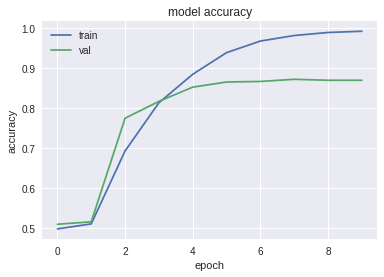

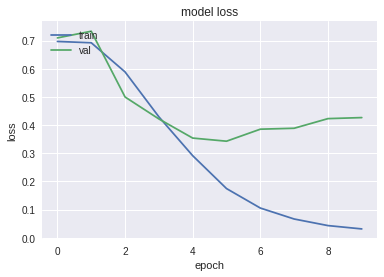

In [0]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()